## Section 1: Problem Statement

As pesticides are expensive to deploy throughout the city, Chicago Department of Public Health (CDPH) has contracted our data scientist team to leverage their data to develop a classification model that could predict the presence of West Nile virus (WNV). With this model, CDPH hopes to create a effective and efficient strategy of deploying spraying of pesticides in Chicago.

## Section 2: Import Libraries and Data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from datetime import time
from datetime import datetime
from datetime import timedelta
from geopy.distance import geodesic
import joblib

from sklearn.feature_selection import SelectKBest, f_regression, RFE,f_classif
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,PowerTransformer,MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report, plot_confusion_matrix, plot_roc_curve, precision_recall_fscore_support,  roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier,BalancedRandomForestClassifier


import plotly.graph_objects as go
import plotly.express as px

MAPBOX_TOKEN = 'pk.eyJ1IjoiZ3VvbG8iLCJhIjoiY2t2M2k5Mjc2MGE1MzJ2bzhzbWlqYnlhNiJ9.GUHAtJh1qWARCbHFYUTLgQ'


pd.set_option("display.max_rows", None, "display.max_columns", None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load datasets
train = pd.read_csv('../datasets/train.csv')
weather = pd.read_csv('../datasets/weather.csv')
spray = pd.read_csv('../datasets/spray.csv')

## Section 3: Data Cleaning & Exploratory Data Analysis

### Section 3.1: Weather Dataset

In [3]:
#check info
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [4]:
# Replace those with blank spaces with nan
weather.replace(r'^\s*$', np.nan, regex=True,inplace=True)

In [5]:
# Many 'M' in values. According to documentation M = 'Missing Data'
for col in weather.columns:
    weather[col] = weather[col].map(lambda x: np.nan if x == 'M' else x)

In [6]:
# to trim whitespaces
weather = weather.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [7]:
# Replace those with - with nan
weather.replace('-', np.nan,inplace=True)

In [8]:
#change data type for date to datetime format
weather['Date'] = weather['Date'].astype('datetime64[ns]')

In [9]:
# Split station 1 and 2
weather_1 = weather[weather['Station']==1].sort_values('Date').reset_index(drop=True)
weather_2 = weather[weather['Station']==2].sort_values('Date').reset_index(drop=True)

In [10]:
#impute missing data in station 1 using station 2 data
weather_2_look = weather_2.set_index('Date')
for col in weather_1.columns:
    for num in range(len(weather_1)):
        if pd.isna(weather_1.loc[num,col]):
            weather_1.loc[num,col] = weather_2_look.loc[weather_1.loc[num,'Date'],col]
        else:
            pass

In [11]:
#impute missing data in station 2 using station 1 data
weather_1_look = weather_1.set_index('Date')
for col in weather_2.columns:
    for num in range(len(weather_2)):
        if pd.isna(weather_2.loc[num,col]):
            weather_2.loc[num,col] = weather_1_look.loc[weather_2.loc[num,'Date'],col]
        else:
            pass

In [12]:
# find the % of null values in descending order
null_percentage = weather_1.isnull().sum()/len(weather_1)*100
null_percentage[null_percentage>0].sort_values(ascending=False)

Water1         100.000000
CodeSum         48.709239
StnPressure      0.067935
dtype: float64

In [13]:
# forward fill for the rest of the null values for station 1
null_percentage = weather_1.isnull().sum()/len(weather_1)*100
null_cols = list(null_percentage[null_percentage>0].index)

for col in null_cols:
    weather_1[col] = weather_1[col].fillna(method='ffill')

In [14]:
# find the % of null values in descending order
null_percentage = weather_1.isnull().sum()/len(weather_1)*100
null_percentage[null_percentage>0].sort_values(ascending=False)

Water1     100.000000
CodeSum      0.067935
dtype: float64

In [15]:
# drop the rest of the null values as there is alot of missing values
weather_1.drop(columns=['CodeSum','Water1'], axis = 1,inplace=True)

In [16]:
# find the % of null values in descending order
null_percentage = weather_2.isnull().sum()/len(weather_2)*100
null_percentage[null_percentage>0].sort_values(ascending=False)

Water1         100.000000
CodeSum         48.709239
StnPressure      0.067935
dtype: float64

In [17]:
# forward fill for the rest of the null values for station 2
null_percentage = weather_2.isnull().sum()/len(weather_2)*100
null_cols = list(null_percentage[null_percentage>0].index)

for col in null_cols:
    weather_2[col] = weather_2[col].fillna(method='ffill')

In [18]:
# drop the rest of the null values as there is alot of missing values
weather_2.drop(columns=['CodeSum','Water1'], axis = 1,inplace=True)

In [19]:
#cocat back the 2 stations
weather_clean = pd.concat([weather_1,weather_2],axis=0).sort_values('Date').reset_index(drop=True)

In [20]:
# find the % of null values in descending order
null_percentage = weather_clean.isnull().sum()/len(weather_clean)*100
null_percentage[null_percentage>0].sort_values(ascending=False)

Series([], dtype: float64)

In [21]:
#check weather info
weather_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   object        
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  Depth        2944 non-null   object        
 13  SnowFall     2944 non-null   object        
 14  PrecipTotal  2944 non-null   object        
 15  StnPressure  2944 non-null   object        
 16  SeaLev

In [22]:
# find the % of null values in descending order
null_percentage = weather_clean.isnull().sum()/len(weather_clean)*100
null_percentage[null_percentage>0].sort_values(ascending=False)

Series([], dtype: float64)

In [23]:
#check for duplicates
weather_clean[weather_clean.duplicated()]

Empty DataFrame
Columns: [Station, Date, Tmax, Tmin, Tavg, Depart, DewPoint, WetBulb, Heat, Cool, Sunrise, Sunset, Depth, SnowFall, PrecipTotal, StnPressure, SeaLevel, ResultSpeed, ResultDir, AvgSpeed]
Index: []

In [24]:
# Some 'T' values. According to documentation T = 'Trace'
weather_clean.isin(['T']).sum()

Station          0
Date             0
Tmax             0
Tmin             0
Tavg             0
Depart           0
DewPoint         0
WetBulb          0
Heat             0
Cool             0
Sunrise          0
Sunset           0
Depth            0
SnowFall        24
PrecipTotal    318
StnPressure      0
SeaLevel         0
ResultSpeed      0
ResultDir        0
AvgSpeed         0
dtype: int64

In [25]:
weather_clean['SnowFall'].value_counts()

0.0    2918
T        24
0.1       2
Name: SnowFall, dtype: int64

In [26]:
weather_clean['PrecipTotal'].value_counts().head()

0.00    1579
T        318
0.01     127
0.02      63
0.03      46
Name: PrecipTotal, dtype: int64

In [27]:
# T = TRACE PRECIPITATION AMOUNT, which means is too small to measure, thus we can decided to fill T between 0 and the next smallest amt (0.01)

weather_clean['PrecipTotal'] = weather_clean['PrecipTotal'].replace('T',float(0.005))
weather_clean['SnowFall'] = weather_clean['SnowFall'].replace('T',float(0.005))

In [28]:
# using sunrise and sunset timing, calculate the number of hours of sunlight which affect the breeding of mostquitoes. Need to account some timing format issues where there is 60min which is to be replaced by 59
sunrise_time = []
for val in weather_clean['Sunrise']:
    try:
        date_val = datetime.strptime(val, '%H%M')
        sunrise_time.append(date_val.hour + date_val.minute/60)
    except:
        date_val = datetime.strptime(val.replace('60', '59'), '%H%M')
        sunrise_time.append(date_val.hour + date_val.minute/60)        

sunset_time = []
for val in weather_clean['Sunset']:
    try:
        date_val = datetime.strptime(val, '%H%M')
        sunset_time.append(date_val.hour + date_val.minute/60)
    except:
        date_val = datetime.strptime(val.replace('60', '59'), '%H%M')
        sunset_time.append(date_val.hour + date_val.minute/60)

# Transform values to hours from midnight
weather_clean['Sunrise'] = sunrise_time
weather_clean['Sunset'] = sunset_time

# Create new feature for sun hours
weather_clean['SunHours'] = weather_clean['Sunset'] - weather_clean['Sunrise']

# Drop Sunrise and Sunset since we have SunHours
weather_clean.drop(columns=['Sunrise', 'Sunset'], inplace=True)

In [29]:
# To convert certain data to numeric

num_cols = ['Tavg', 'Depart','WetBulb', 'Heat','Depth','SnowFall', 'Cool', 'PrecipTotal','StnPressure','SeaLevel','AvgSpeed']

for col in num_cols:
    weather_clean[col]= pd.to_numeric(weather_clean[col])

In [30]:
# Function to calculate relative humidity (https://www.wral.com/how-to-calculate-relative-humidity/1174528/)
# relative humidity affects wnv transmission (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4342965/)
def rel_hum(Tavg,DewPoint):
    #converted temperature to celcius
    t_cel = (5/9)*(Tavg-32)
    d_cel = (5/9)*(DewPoint-32)
    # Calculated vapour pressure and actual pressure
    saturation_vapor_pressure = 6.11*10.0**(7.5*t_cel/(237.7+t_cel))
    vapor_pressure  = 6.11*10.0**(7.5*d_cel/(237.7+d_cel))
    #return relative humidity
    return round(((vapor_pressure/saturation_vapor_pressure)*100))

In [31]:
# New column with Relative humidity values are created from the function
weather_clean['rel_hum'] = np.vectorize(rel_hum)(weather_clean['Tavg'],weather_clean['DewPoint'])

In [32]:
# add columns for week year and month year for usage later
weather_clean['week_Year'] = weather_clean['Date'].dt.strftime('%W-%Y')


In [33]:
weather_cleanest = weather_clean.copy()
avg_week = weather_cleanest[['week_Year','Station','Tavg','WetBulb','DewPoint','Heat','Cool','Depart','Tmin','SunHours','Tmax','ResultSpeed','AvgSpeed','SnowFall','PrecipTotal','StnPressure','SeaLevel','ResultDir','rel_hum']].groupby(by=['week_Year','Station']).mean().reset_index()


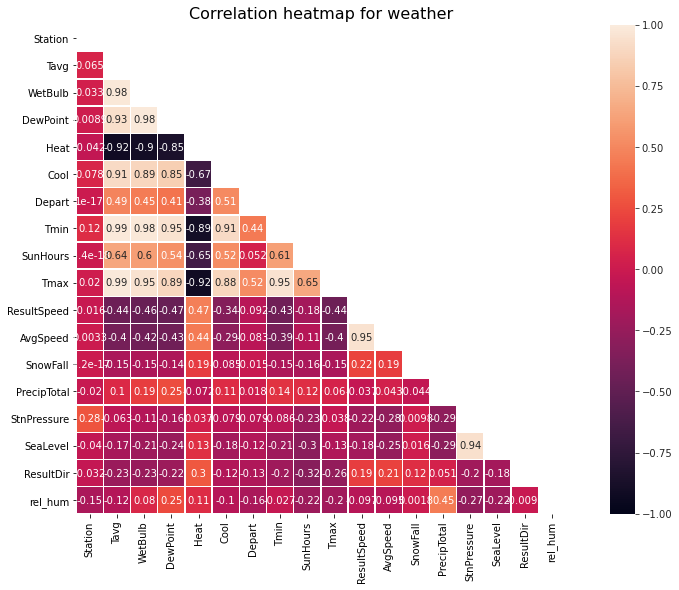

In [34]:
# Establish size of figure.
plt.figure(figsize = (16,9))

# Set title for the figure.
plt.title('Correlation heatmap for weather',size=16)

# Get correlation of variables
corr = avg_week.corr()

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.

with sns.axes_style("white"):
    sns.heatmap(corr, mask = mask, square = True, annot = True, vmin = -1, vmax = 1, linewidths = 0.5)

In [35]:
# removed those with correlation 0.95 and more
avg_week = avg_week.drop(columns=['Tavg','ResultSpeed','WetBulb'],axis=1)

<AxesSubplot:xlabel='Date', ylabel='SunHours'>

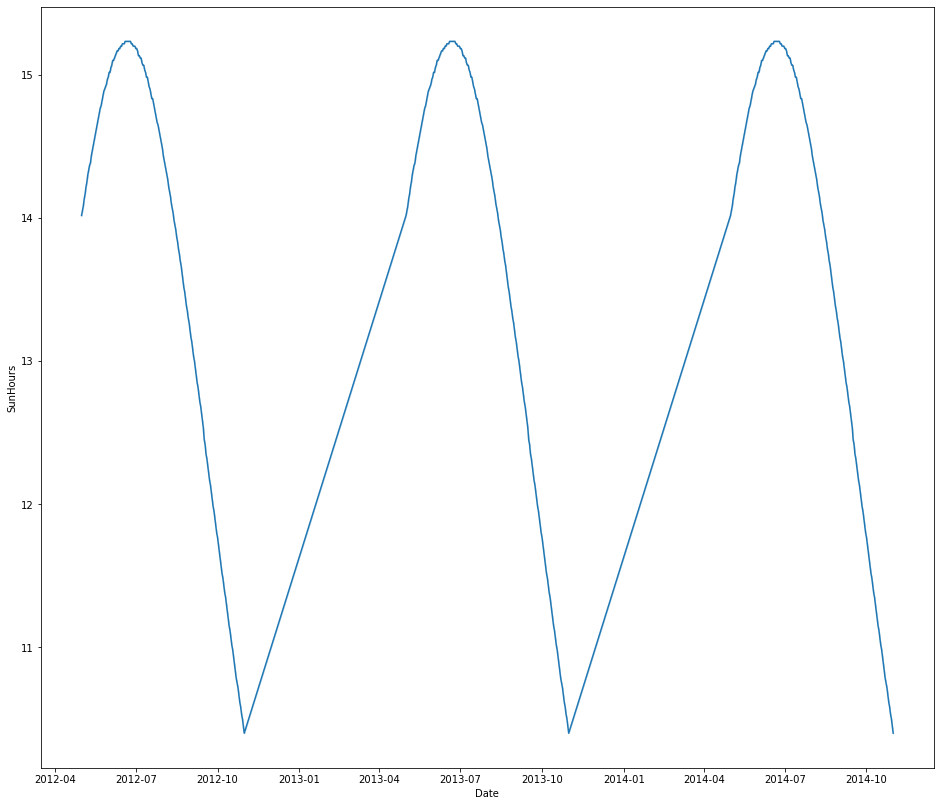

In [36]:
#plot sunhours and can see that it is cyclical/seasonal
plt.figure(figsize=(16,14))
sns.lineplot(x='Date',y='SunHours',data=weather_cleanest[weather_cleanest['Date'].dt.year.isin([2012,2013,2014])])


<AxesSubplot:xlabel='Date', ylabel='Tavg'>

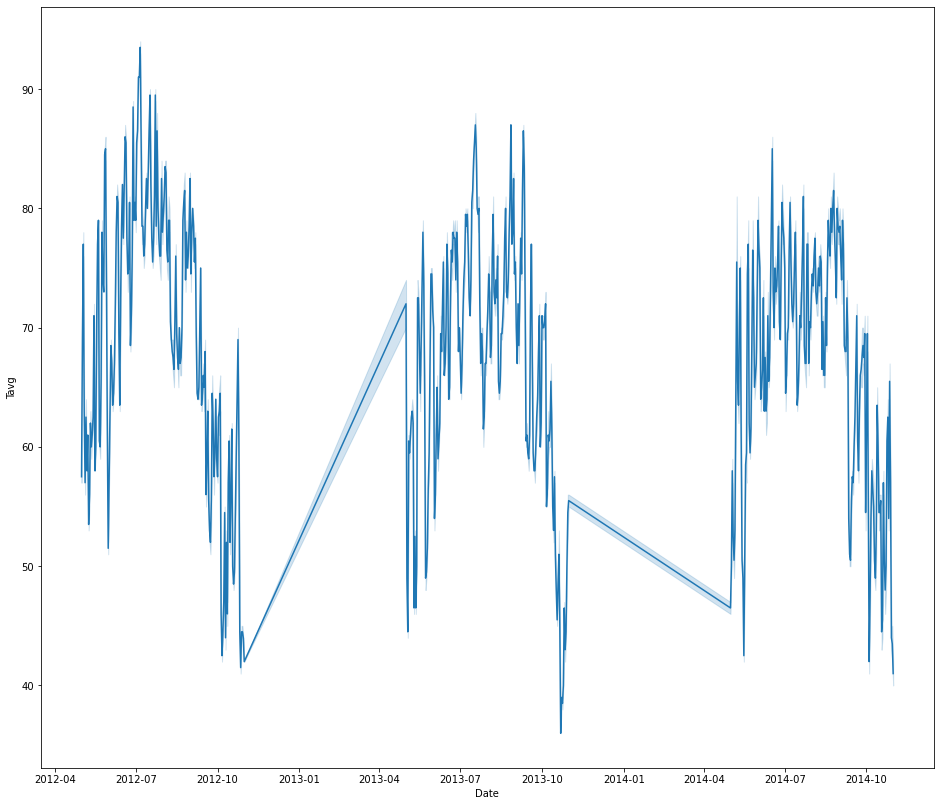

In [37]:
#plot temperature similar to sunhours
plt.figure(figsize=(16,14))
sns.lineplot(x='Date',y='Tavg',data=weather_cleanest[weather_cleanest['Date'].dt.year.isin([2012,2013,2014])])

Text(0.5, 1.0, 'Pressure values Distribution')

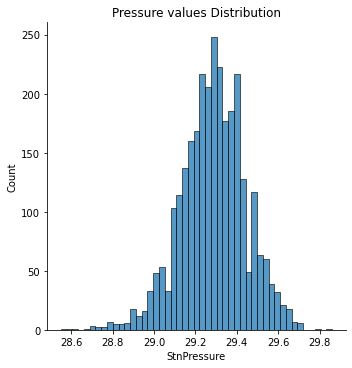

In [38]:
#plot stnpressure
sns.displot(weather_cleanest['StnPressure'])
plt.title('Pressure values Distribution')

Text(0.5, 1.0, 'Sea level distributions')

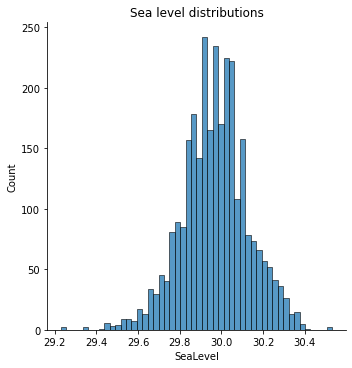

In [39]:
#plot sealevel
sns.displot(weather_cleanest['SeaLevel'])
plt.title('Sea level distributions')

Text(0.5, 1.0, 'Sea level distributions')

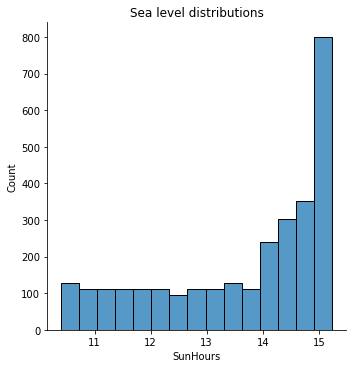

In [40]:
#plot sealevel
sns.displot(weather_cleanest['SunHours'])
plt.title('Sea level distributions')

### Section 3.2: Training Dataset

In [41]:
# look at train information such as null values and datatypes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


In [42]:
# Replace those with blank spaces with nan if any
train.replace(r'^\s*$', np.nan, regex=True,inplace=True)

In [43]:
#change data type for date to datetime format
train['Date'] = train['Date'].astype('datetime64[ns]')

In [44]:
#create month columns from date
train['month'] = train['Date'].dt.strftime('%B')

In [45]:
# find the % of null values in descending order
null_percentage = train.isnull().sum()/len(train)*100
null_percentage[null_percentage>0].sort_values(ascending=False)

Series([], dtype: float64)

In [46]:
# As the number of mosquitos is capped at 50 per trap, this resulted in alot of duplicates. Thus we need to groupby and sum the number of mosquitos to remove duplicates
train = train.groupby(['Date','month','Species','Trap','Address','Block','Street','AddressNumberAndStreet','Latitude',
                            'Longitude','WnvPresent','AddressAccuracy'], as_index=False).sum().sort_values(by='Date').reindex()

In [47]:
# create week-year for the merged data
train['week_Year'] = train['Date'].dt.strftime('%W-%Y')
train['week_Year_lag'] = (train['Date'] - timedelta(weeks=1)).dt.strftime('%W-%Y')
train['twoweek_Year_lag'] = (train['Date'] - timedelta(weeks=2)).dt.strftime('%W-%Y')

In [48]:
#imbalance dataset as shown
train['WnvPresent'].value_counts(normalize=True)

0    0.946922
1    0.053078
Name: WnvPresent, dtype: float64

In [49]:
# map view of mosquitoes Traps by species by num and locatinos

px.set_mapbox_access_token(MAPBOX_TOKEN)

fig = px.scatter_mapbox(train, lat='Latitude', lon='Longitude',     color="Species", size="NumMosquitos",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=40, zoom=10)

fig.update_layout(title = 'Number of Mosquitos Trapped by spieces and location',
    autosize=False,
    width=1000,
    height=700,)
fig.show()

In [50]:
# count west nile virus present groupby address.
wnv = train.groupby(['Address'], as_index = False)[['WnvPresent']].sum()

# Count no. of mosquitos groupby address
mosq = train.groupby(['Address'], as_index = False)[['NumMosquitos']].sum()

# group the area
area = train.groupby(['Address'], as_index = False)[['Latitude', 'Longitude']].median()

#concat the df and drop address column. we will not need the address column
areas_wnv = pd.concat([area, mosq, wnv], axis = 1).drop(columns = 'Address')

# select areas where there is WNV present
wnv = areas_wnv[areas_wnv['WnvPresent'] >= 0]

#Plot areas where WNV is detected

fig = px.scatter_mapbox(wnv, lat = 'Latitude', lon  = 'Longitude', color = 'WnvPresent', size = 'WnvPresent',
                      size_max=18, zoom = 10 )

fig.update_layout(
    title="Areas where WNV is detected",
        width=800,
    height=700
)

fig.show()

Text(0, 0.5, 'Total')

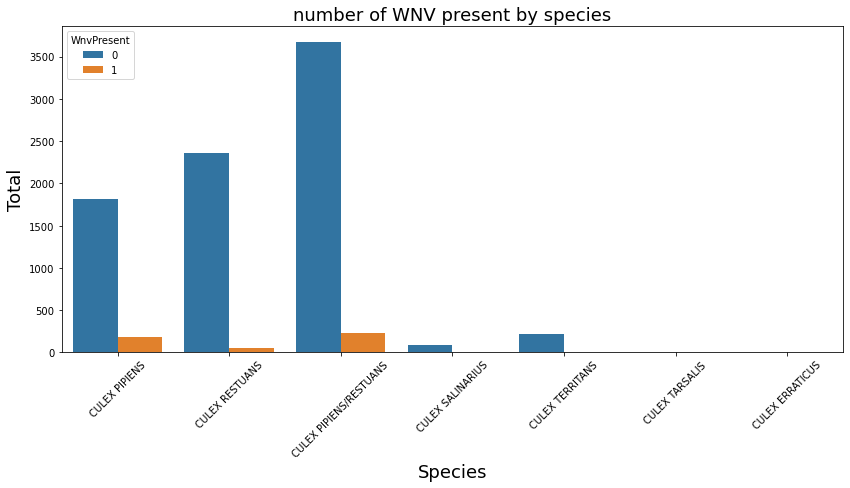

In [51]:
# plot total number of mosquitos by type of species and WnvPresent

plt.figure(figsize=(14,6))
plt.title('number of WNV present by species',fontsize=18)
sns.countplot(x='Species',hue='WnvPresent',data= train)
plt.xticks(rotation = 45)
plt.xlabel('Species', fontsize=18)
plt.ylabel('Total', fontsize=18)

Text(0, 0.5, 'Total')

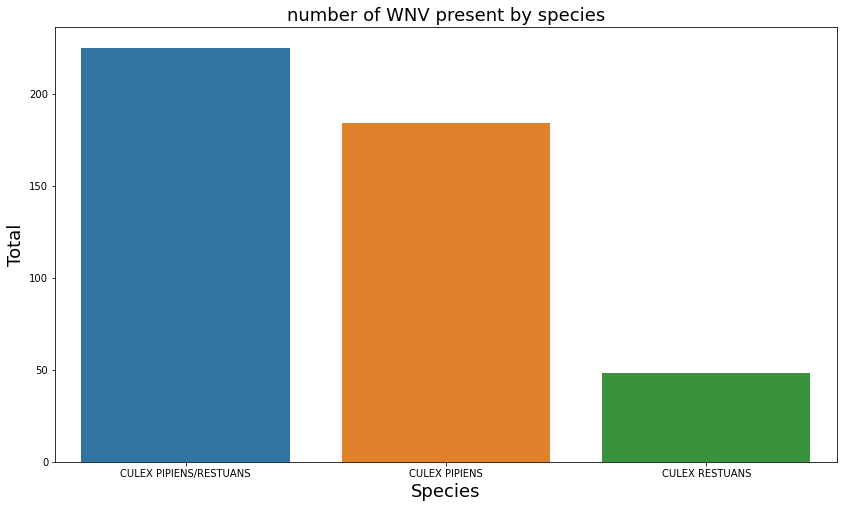

In [52]:
# type of species with WnvPresent

plt.figure(figsize=(14,8))
plt.title('number of WNV present by species',fontsize=18)
sns.countplot(x='Species',data= train[train['WnvPresent']==1])
plt.xlabel('Species', fontsize=18)
plt.ylabel('Total', fontsize=18)

In [53]:
# create a dictionary to calculate the % of WnvPresent for each species
percentage_wnv = train[['Species','WnvPresent','NumMosquitos']].groupby('Species').sum()
percentage_wnv['percentage'] = round(percentage_wnv['WnvPresent']/percentage_wnv['NumMosquitos']*100,3)
percentage_wnv.drop(columns=['WnvPresent','NumMosquitos'],axis=1,inplace=True)
percentage_wnv = percentage_wnv.T.to_dict('records')[0]
print(percentage_wnv)

{'CULEX ERRATICUS': 0.0, 'CULEX PIPIENS': 0.412, 'CULEX PIPIENS/RESTUANS': 0.34, 'CULEX RESTUANS': 0.205, 'CULEX SALINARIUS': 0.0, 'CULEX TARSALIS': 0.0, 'CULEX TERRITANS': 0.0}


In [54]:
#convert to num by mapping the % of mosquitoes
train['species_num'] = train['Species'].map(percentage_wnv)

Text(0, 0.5, 'Total')

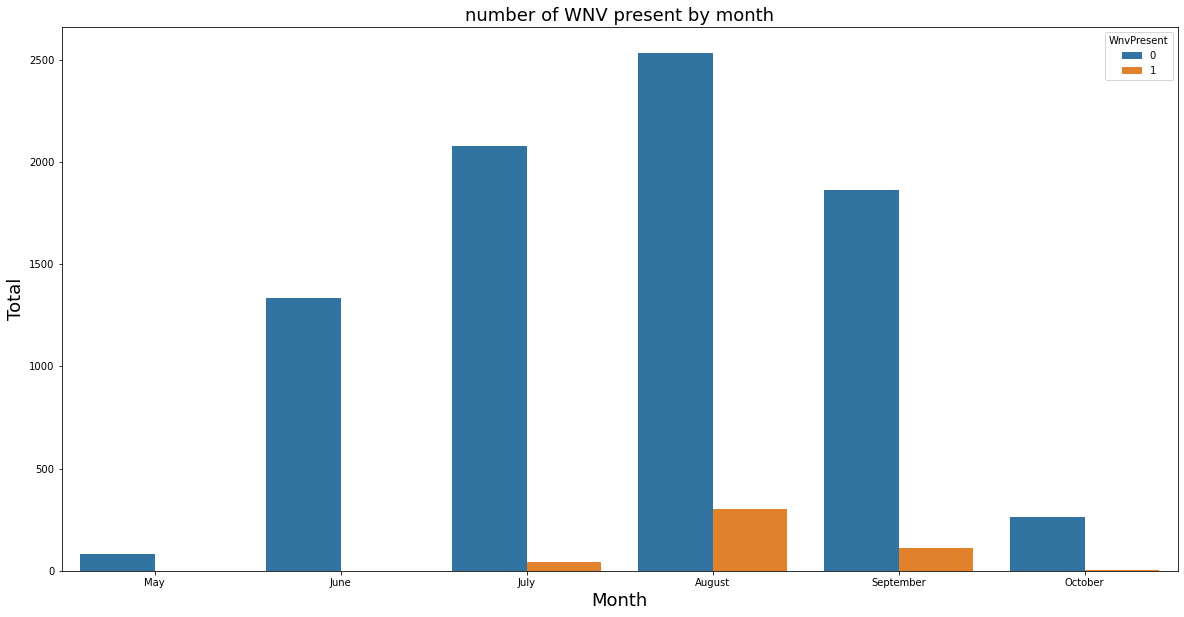

In [55]:
# plot the number of mosquitos by month and WnvPresent

plt.figure(figsize=(20,10))
plt.title('number of WNV present by month',fontsize=18)
sns.countplot(x='month',hue='WnvPresent',data= train)
plt.xlabel('Month', fontsize=18)
plt.ylabel('Total', fontsize=18)

In [56]:
# create a dictionary to calculate the % of total wnvPresent by month
percentage_mos_mth = train[['month','NumMosquitos']].groupby('month').sum()
percentage_mos_mth['percentage'] = round(percentage_mos_mth['NumMosquitos']/train['NumMosquitos'].sum()*100,3)
percentage_mos_mth.drop(columns=['NumMosquitos'],axis=1,inplace=True)
percentage_mos_mth = percentage_mos_mth.T.to_dict('records')[0]
print(percentage_mos_mth)

{'August': 42.977, 'July': 27.583, 'June': 12.276, 'May': 0.17, 'October': 1.42, 'September': 15.573}


In [57]:
#convert  month to num by mapping the % of total WnvPresent
train['month_num'] = train['month'].map(percentage_mos_mth)

In [58]:
# calculate geodoesic distance between each row and the 2 stations. Map the weather stations for each row to the nearer weather station
station1 = (41.995, -87.933) #Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT
station2 = (41.786, -87.752) #Station 2: CHICAGO MIDWAY INTL ARPT
def get_station(lat, long):
    dist1 = geodesic((lat, long), station1).km
    dist2 = geodesic((lat, long), station2).km
    return 1 if dist1 < dist2 else 2

train['Station'] = [get_station(train.loc[i,'Latitude'],train.loc[i,'Longitude']) for i in train.index]

In [59]:
# Create 10 clusters using Kmeans based on location
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10, random_state=42)
kmeans.fit(train[['Latitude','Longitude']])
train['location'] = kmeans.predict(train[['Latitude','Longitude']]).astype(object)

Text(0, 0.5, 'Total')

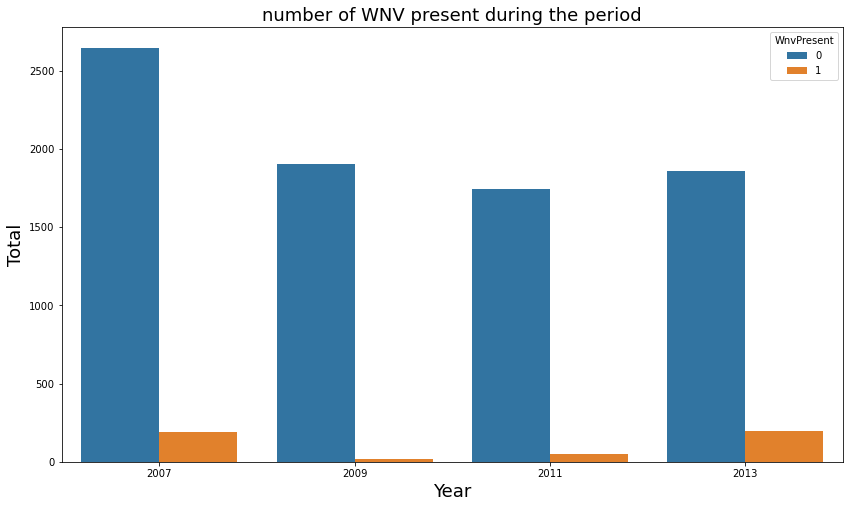

In [60]:
#Plot the breakdown of WnvPresent by species and year

plt.figure(figsize=(14,8))
sns.countplot(x=train['Date'].dt.year,hue=train['WnvPresent'])
plt.title('number of WNV present during the period',fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Total', fontsize=18)

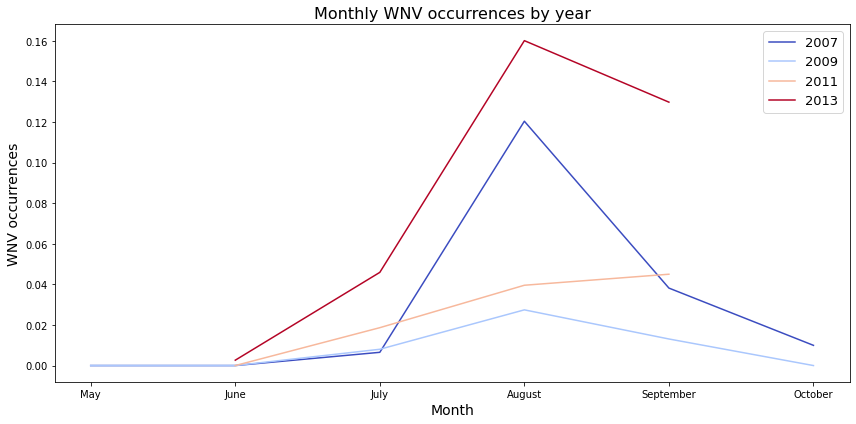

In [61]:
#Plot WNV occurrences by year and months 
plt.figure(figsize=(12,6))
sns.lineplot(data = train, x='month', y='WnvPresent', hue=train['Date'].dt.year, ci = None,
             palette = 'coolwarm')
plt.legend(fontsize = 13)
plt.title('Monthly WNV occurrences by year', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('WNV occurrences',fontsize=14)
plt.tight_layout()

Text(0, 0.5, 'Total')

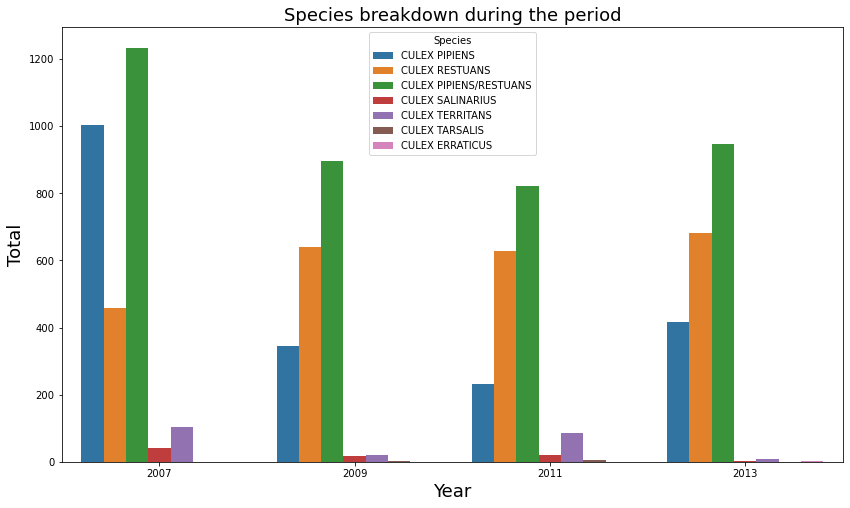

In [62]:
#Plot the breakdown of number of mosquitos by species and year
plt.figure(figsize=(14,8))
sns.countplot(x=train['Date'].dt.year,hue=train['Species'])
plt.title('Species breakdown during the period',fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Total', fontsize=18)

In [63]:
### Section 3.3 Spray Data

In [64]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [65]:
# convert column date to datetime
spray['Date'] = spray['Date'].astype('datetime64[ns]')

In [66]:
spray['Date'].value_counts()

2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2011-09-07    2114
2013-07-25    1607
2013-08-22    1587
2013-08-08    1195
2013-09-05     924
2013-08-16     141
2011-08-29      95
Name: Date, dtype: int64

In [67]:
#check for null values
spray.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

In [68]:
# drop time as it has alot of null values
spray.drop(columns='Time',inplace=True)

#drop duplicates
spray.drop_duplicates(inplace=True,ignore_index=True)

In [69]:
# since spray is only for 2011 and 2013 we need obtain data only for these 2 years

num_mos = train[train['Date'].dt.year.isin([2011,2013])].groupby('Date')['NumMosquitos'].sum()

spray_dates = spray['Date'].unique()

In [70]:
#Explore the effectiveness of spraying at areas for 2013

spray_2013 = spray[spray['Date'].dt.year==2013]
num_wnv_2013 = train[train['Date'].dt.year.isin([2013])].groupby(['Date','Latitude','Longitude'])['WnvPresent','NumMosquitos'].sum().reset_index()
fig1 = px.scatter_mapbox(spray_2013, lat = 'Latitude', lon  = 'Longitude',
                      size_max=15, zoom = 9, color_discrete_sequence=["palegoldenrod"],  opacity = 0.4
                         )

fig2 = px.scatter_mapbox(num_wnv_2013, lat='Latitude', lon='Longitude', color = 'WnvPresent', size = 'NumMosquitos',    
                         size_max=15, zoom = 9 )


fig1.add_trace(fig2.data[0])

fig1.update_layout( title = 'Mosquito Clusters with Presence of WNV and overview of Sprayed Areas for 2013 ',
                width=800,
    height=700,
)

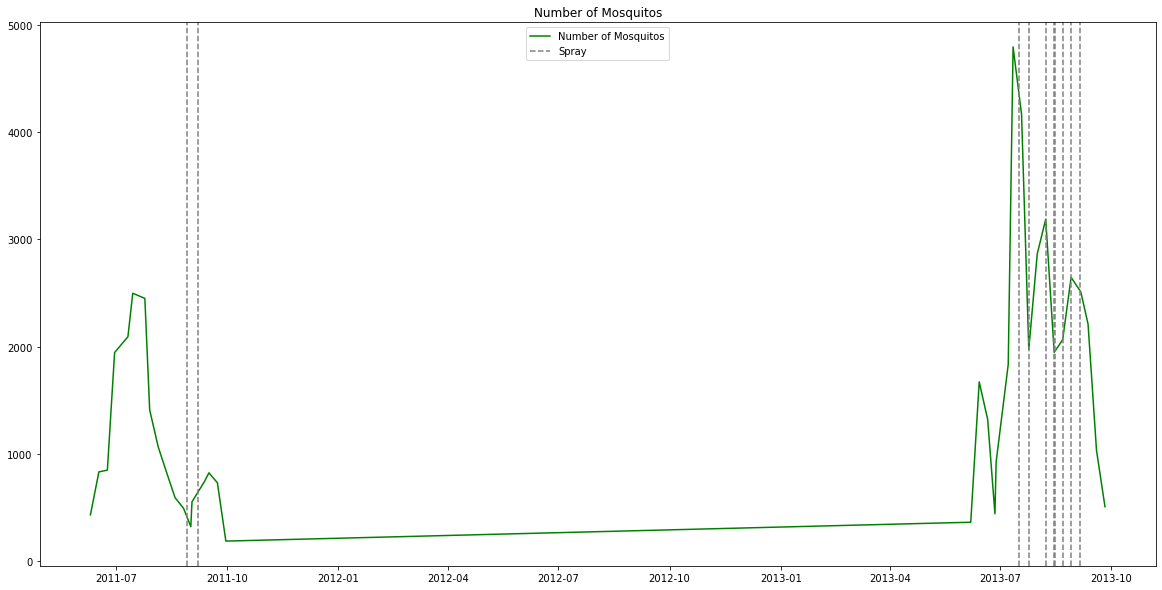

In [71]:
# plot the number of mosquitoes vs spray 
plt.figure(figsize=(20,10))
plt.plot(num_mos.index,num_mos.values,color='green')
for spray_date in spray_dates:
    plt.axvline(x=spray_date, color='grey', ls='--')
plt.title('Number of Mosquitos')
plt.legend(['Number of Mosquitos','Spray']);

**Note**: As we can see from the graph above, the spraying does not seem to affect the number of mosquitoes. Thus, we will not be using this data in our model.

### Section 3.5: Merge Train and Weather Dataset

In [72]:
# merged with weather to create a average 1 and 2 week lag weather data 
train_merged = train.merge(avg_week, how='inner',left_on=['week_Year_lag','Station'], right_on=['week_Year','Station'],suffixes=('', '1lag'))
train_merged = train_merged.merge(avg_week, how='inner',left_on=['twoweek_Year_lag','Station'], right_on=['week_Year','Station'],suffixes=('', '2lag'))

In [73]:
# check the merged data information if it is correct
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8610 entries, 0 to 8609
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    8610 non-null   datetime64[ns]
 1   month                   8610 non-null   object        
 2   Species                 8610 non-null   object        
 3   Trap                    8610 non-null   object        
 4   Address                 8610 non-null   object        
 5   Block                   8610 non-null   int64         
 6   Street                  8610 non-null   object        
 7   AddressNumberAndStreet  8610 non-null   object        
 8   Latitude                8610 non-null   float64       
 9   Longitude               8610 non-null   float64       
 10  WnvPresent              8610 non-null   int64         
 11  AddressAccuracy         8610 non-null   int64         
 12  NumMosquitos            8610 non-null   int64   

In [74]:
# find  correlated variables to consider for feature engineering
abs(train_merged.corr()['WnvPresent']).sort_values(ascending=False)

WnvPresent         1.000000
month_num          0.148644
AvgSpeed2lag       0.118180
species_num        0.117717
DewPoint2lag       0.116899
DewPoint           0.095978
Tmin2lag           0.095709
AvgSpeed           0.090931
rel_hum            0.086188
Cool2lag           0.085483
Heat2lag           0.084879
Tmax2lag           0.084557
rel_hum2lag        0.080457
Longitude          0.074075
Tmin               0.072580
Heat               0.068122
Station            0.065179
SunHours           0.060787
PrecipTotal        0.060590
SeaLevel           0.057663
NumMosquitos       0.055553
Cool               0.053871
SunHours2lag       0.045648
Tmax               0.044388
StnPressure        0.037430
PrecipTotal2lag    0.037190
SnowFall           0.033375
Latitude           0.030907
ResultDir          0.028340
SnowFall2lag       0.026609
Depart2lag         0.019018
StnPressure2lag    0.018788
Block              0.011303
Depart             0.009693
AddressAccuracy    0.007886
ResultDir2lag      0

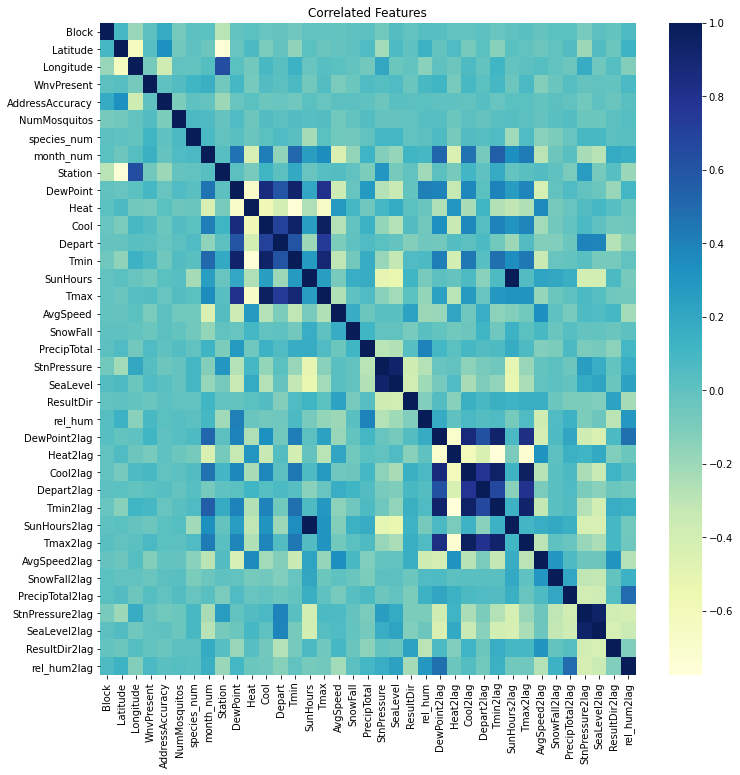

In [75]:
#correlation plot
plt.figure(figsize = (12,12))
plt.title('Correlated Features')
sns.heatmap(train_merged.corr(),  cmap="YlGnBu");

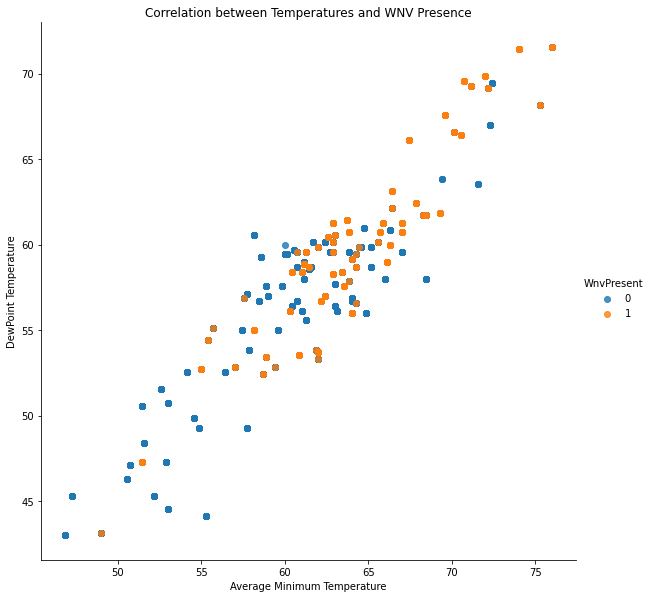

In [76]:
# plot corr between temp and wnv presence
sns.lmplot( x='Tmin', y='DewPoint', data=train_merged, fit_reg=False, hue='WnvPresent', height=8)
plt.title('Correlation between Temperatures and WNV Presence')
plt.xlabel('Average Minimum Temperature')
plt.ylabel('DewPoint Temperature');

## Section 4: Feature Engineering/Feature Selection

In [77]:
# Drop num of mosquitos as it is not in the test set, also dropped those unnecessary columns
y = train_merged['WnvPresent']
X = train_merged.drop(columns=['month','Block','Street','AddressNumberAndStreet','Address','AddressAccuracy','WnvPresent','Date','Station','NumMosquitos',
                               'week_Year_lag','twoweek_Year_lag','Species','week_Year',
                               'week_Year1lag','week_Year2lag'])

In [78]:
#check for null values
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8610 entries, 0 to 8609
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Trap             8610 non-null   object 
 1   Latitude         8610 non-null   float64
 2   Longitude        8610 non-null   float64
 3   species_num      8610 non-null   float64
 4   month_num        8610 non-null   float64
 5   location         8610 non-null   object 
 6   DewPoint         8610 non-null   float64
 7   Heat             8610 non-null   float64
 8   Cool             8610 non-null   float64
 9   Depart           8610 non-null   float64
 10  Tmin             8610 non-null   float64
 11  SunHours         8610 non-null   float64
 12  Tmax             8610 non-null   float64
 13  AvgSpeed         8610 non-null   float64
 14  SnowFall         8610 non-null   float64
 15  PrecipTotal      8610 non-null   float64
 16  StnPressure      8610 non-null   float64
 17  SeaLevel      

In [79]:
# create dummies for catergorical data (Trap)
X = pd.get_dummies(data=X)

## Section 5: Modelling

In [80]:
# train test split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, random_state=42, test_size=0.2,stratify=y)

In [81]:
# Scaling
ss = MinMaxScaler()
X_scaled_train = ss.fit_transform(X_train)
X_scaled_validation = ss.transform(X_validation)

###  Section 5.1: Logistic Regression

In [82]:
# Instantiate SMOTE to account for unbalance dataset
sm = SMOTE(random_state=42)


In [83]:
# Pipeline for Logistic regression

lr = LogisticRegression(max_iter=10000)

pipe_lr = Pipeline([
        ('sm', sm),
        ('lr', lr)
    ])

# Hyperparameters
lr_params = {
    'lr__C': np.linspace(0.1,1,5),
    'lr__solver': ['lbfgs','newton-cg']
}

In [84]:
# Instantiate 5-fold GridSearchCV.
gs_lr = GridSearchCV(pipe_lr, param_grid = lr_params, cv=5,
                     scoring='roc_auc',n_jobs=-1,
             )

# Fit GridSearch to training data.
gs_lr.fit(X_scaled_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=42)),
                                       ('lr',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'lr__C': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
                         'lr__solver': ['lbfgs', 'newton-cg']},
             scoring='roc_auc')

In [85]:
# find best parameters for logistic regression from the hyper parameter tuning
gs_lr.best_params_

{'lr__C': 0.1, 'lr__solver': 'lbfgs'}

In [86]:
# Instantiate SMOTE

X_sm_train, y_sm_train = sm.fit_resample(X_scaled_train, y_train)

In [87]:
# Instantiate and fit logistic regression based on best parameters
lr = LogisticRegression(solver='lbfgs', C=0.1,max_iter=10000,n_jobs=-1,random_state=42)
lr.fit(X_sm_train, y_sm_train)

LogisticRegression(C=0.1, max_iter=10000, n_jobs=-1, random_state=42)

In [88]:
# function to plot top features
def topfeatures(weightage,features,no_of_feat):
    feature_impt = pd.DataFrame(data=abs(weightage),index=features,columns=['impt']).reset_index().sort_values(by='impt',ascending=False).head(no_of_feat)
    feature_impt.columns = ['features','impt']
    plt.figure(figsize=(14,8))
    plt.title('Feature Importance',fontsize=18)
    sns.barplot(data=feature_impt,y='features',x='impt',color='grey')
    plt.xlabel('Weightage', fontsize=12)
    plt.ylabel('Features', fontsize=12)

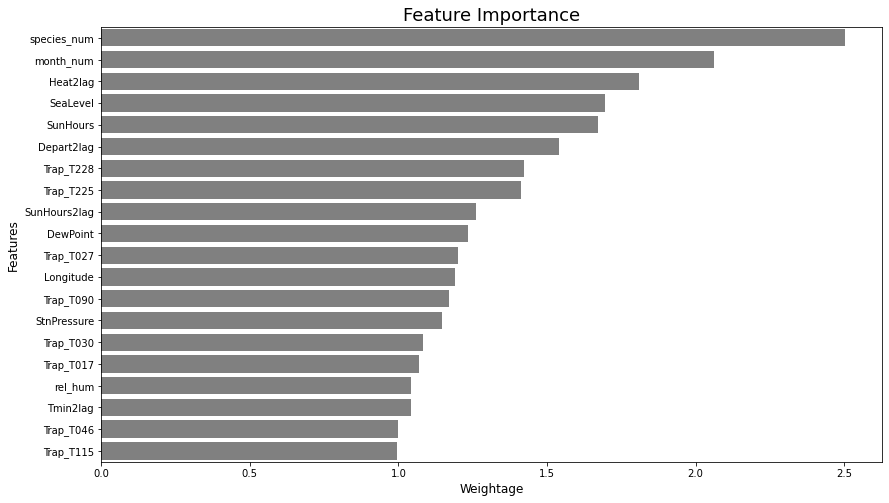

In [89]:
# to plot top 20 features
topfeatures(lr.coef_[0],X_train.columns,20)

In [90]:
# create function to plot classification report and confusion matrix
def matrix(model,X,y):
    preds = model.predict(X)
    print('Classification Report')
    print(classification_report(y,preds))
    print('Confusion Matrix')
    print(plot_confusion_matrix(model,X,y))
    

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1631
           1       0.14      0.74      0.23        91

    accuracy                           0.74      1722
   macro avg       0.56      0.74      0.54      1722
weighted avg       0.94      0.74      0.81      1722

Confusion Matrix


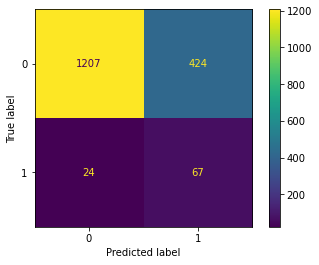

In [91]:
#plot matrix using function
matrix(lr,X_scaled_validation,y_validation)

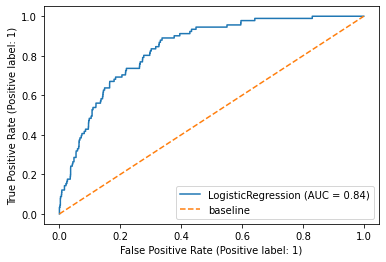

In [92]:
# plot ROC curve which shows that is better than baseline (random classifier)
plot_roc_curve(lr, X_scaled_validation, y_validation)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

###  Section 5.1: Random Forest

In [93]:
#Instantiate randomforest classifier. Balanced for class weight to account for imbalance data
rf = RandomForestClassifier(class_weight='balanced',random_state=42)

In [94]:

# Hyperparameters
rf_params = {
    'n_estimators': [50,100],
    'min_samples_leaf': [4,6],
    'min_samples_split' : [2,4]
}

In [95]:
# Instantiate 5-fold GridSearchCV.
gs_rf = GridSearchCV(rf, param_grid = rf_params, cv=5,
                     scoring='roc_auc',n_jobs=-1,
             )

# Fit GridSearch to training data.
gs_rf.fit(X_scaled_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'min_samples_leaf': [4, 6],
                         'min_samples_split': [2, 4],
                         'n_estimators': [50, 100]},
             scoring='roc_auc')

In [96]:
# find best parameters for random forest from the hyper parameter tuning
gs_rf.best_params_

{'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 100}

In [97]:
# Instantiate and fit random forest based on best parameters
rf = RandomForestClassifier(n_estimators=100,min_samples_leaf=6, min_samples_split=2,random_state=42,class_weight='balanced')
rf.fit(X_scaled_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=6,
                       random_state=42)

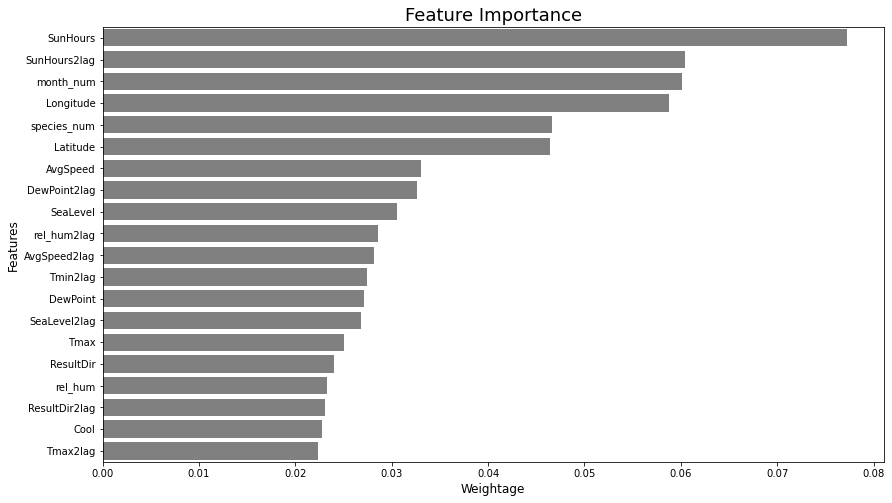

In [98]:
# to plot top 20 features
topfeatures(rf.feature_importances_,X_train.columns,20)

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.82      0.90      1631
           1       0.19      0.74      0.30        91

    accuracy                           0.82      1722
   macro avg       0.59      0.78      0.60      1722
weighted avg       0.94      0.82      0.86      1722

Confusion Matrix


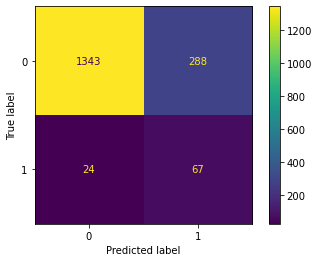

In [99]:
# plot confusion matrix
matrix(rf,X_scaled_validation,y_validation)

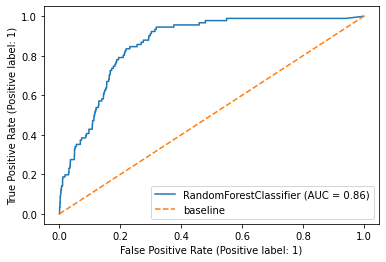

In [100]:
# plot ROC curve which shows that is better than baseline (random classifier)
plot_roc_curve(rf, X_scaled_validation, y_validation)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

###  Section 5.3: Model Evaluation

In [101]:
# function to evaluate model
def evaluate_model(model_name,model,X_train,y_train,X_test,y_test):
    train_auc = np.mean(cross_val_score(model, X_train, y_train, scoring = 'roc_auc', cv = 5))
    preds = model.predict(X_test)
    test_auc = roc_auc_score(y_test, preds)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, preds,average='weighted')
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test,y_test)
    accuracy_variance = train_accuracy/test_accuracy
    summary1 = {'Model_name' : model_name,
                'train_accuracy': round(train_accuracy,3),
                'test_accuracy': round(test_accuracy,3),
                'accuracy_variance' :round(accuracy_variance,3),
                'train_auc': round(train_auc,3),
                'test_auc': round(test_auc,3),
                'Precision': round(precision,3),
                'recall': round(recall,3),
                'fscore' : round(fscore,3)}
    summary= pd.DataFrame([summary1])
    return summary
    

In [102]:
#evaluation results for 2 models
# although accuracy is not used to evaluate model due to imbalance classification, it is used to test for overfitting
pd.concat([evaluate_model('logistic regression',lr,X_sm_train,y_sm_train,X_scaled_validation,y_validation),
          evaluate_model('randomforest',rf,X_scaled_train,y_train,X_scaled_validation,y_validation)],axis=0).reset_index(drop=True)

Model_name  train_accuracy  test_accuracy  accuracy_variance  \
0  logistic regression           0.799          0.740              1.080   
1         randomforest           0.819          0.819              1.001   

   train_auc  test_auc  Precision  recall  fscore  
0      0.869     0.738      0.936   0.740   0.811  
1      0.821     0.780      0.940   0.819   0.864

**Note**: As this is data classification set is highly unbalanced, we should not be using accuracy to evaluate model. Thus, we select RandomForestClassifier as it has the higher test_auc score,recall and fscore. Based on the train accuracy vs test accuracy(accuracy variance), we can see that logistic regression is slightly overfitted and thus will not generalised well as compared to the RandomForestClassifier. We also select the one with higher recall as we would rather additionally spray an area without WNV than miss out on sprayig an area with WNV.

## Section 6: Fit best model

In [103]:
# from the evaluation, select best model to fit to the full train data to make full use of the trainin dataset
final_model = RandomForestClassifier(n_estimators=100,min_samples_leaf=6, min_samples_split=2,random_state=42,class_weight='balanced')

In [104]:
# min max scale for X
X_scaled = ss.fit_transform(X)

In [105]:
# fit to the best model
final_model.fit(X_scaled, y)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=6,
                       random_state=42)

In [106]:
# auc score
preds = final_model.predict(X_scaled)
auc = roc_auc_score(y, preds)
auc

0.8428863628616925

In [107]:
#save final model
joblib.dump(final_model,'final_model.pkl')

['final_model.pkl']

In [108]:
#save scaler 
joblib.dump(ss,'MinMaxScaler.pkl')

['MinMaxScaler.pkl']

In [109]:
#save features used to train model
joblib.dump(X.columns,'X_columns.pkl')

['X_columns.pkl']

## Section 7: Kaggle submssion

In [110]:
#import test data
test = pd.read_csv('../datasets/test.csv')

In [111]:
#test information
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Date                    116293 non-null  object 
 2   Address                 116293 non-null  object 
 3   Species                 116293 non-null  object 
 4   Block                   116293 non-null  int64  
 5   Street                  116293 non-null  object 
 6   Trap                    116293 non-null  object 
 7   AddressNumberAndStreet  116293 non-null  object 
 8   Latitude                116293 non-null  float64
 9   Longitude               116293 non-null  float64
 10  AddressAccuracy         116293 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


In [112]:
# convert data type to datetime
test['Date'] = test['Date'].astype('datetime64[ns]')

In [113]:
# mapped each role to the nearest weather station
test['Station'] = [get_station(test.loc[i,'Latitude'],test.loc[i,'Longitude']) for i in test.index]

In [114]:
# create week year and month columns from date
test['week_Year'] = test['Date'].dt.strftime('%W-%Y')
test['month'] = test['Date'].dt.strftime('%B')
test['week_Year_lag'] = (test['Date'] - timedelta(weeks=1)).dt.strftime('%W-%Y')
test['twoweek_Year_lag'] = (test['Date'] - timedelta(weeks=2)).dt.strftime('%W-%Y')

In [115]:
# merged with weather data
test = test.merge(avg_week, how='left',left_on=['week_Year_lag','Station'], right_on=['week_Year','Station'],suffixes=('', '1lag'))
test = test.merge(avg_week, how='left',left_on=['twoweek_Year_lag','Station'], right_on=['week_Year','Station'],suffixes=('', '2lag'))

In [116]:
#convert to num by mapping the % of mosquitoes
test['species_num'] = test['Species'].map(percentage_wnv)
test.loc[test['species_num'].isnull(),'species_num'] = 0

In [117]:
#convert to num by mapping the % of WnvPresent by month
test['month_num'] = test['month'].map(percentage_mos_mth)
test.loc[test['month_num'].isnull(),'month_num'] = 0

In [118]:
test['location'] = kmeans.predict(test[['Latitude','Longitude']]).astype(object)

In [119]:
#check test information
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 49 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      116293 non-null  int64         
 1   Date                    116293 non-null  datetime64[ns]
 2   Address                 116293 non-null  object        
 3   Species                 116293 non-null  object        
 4   Block                   116293 non-null  int64         
 5   Street                  116293 non-null  object        
 6   Trap                    116293 non-null  object        
 7   AddressNumberAndStreet  116293 non-null  object        
 8   Latitude                116293 non-null  float64       
 9   Longitude               116293 non-null  float64       
 10  AddressAccuracy         116293 non-null  int64         
 11  Station                 116293 non-null  int64         
 12  week_Year               116293

In [120]:
X_test = test.drop(columns=['Station','month','Street','Address','Block','AddressNumberAndStreet','AddressAccuracy','Id','Date',
                            'week_Year_lag','twoweek_Year_lag','Species','week_Year',
                               'week_Year1lag','week_Year2lag'])

In [121]:
#check test information
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 34 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Trap             116293 non-null  object 
 1   Latitude         116293 non-null  float64
 2   Longitude        116293 non-null  float64
 3   DewPoint         116293 non-null  float64
 4   Heat             116293 non-null  float64
 5   Cool             116293 non-null  float64
 6   Depart           116293 non-null  float64
 7   Tmin             116293 non-null  float64
 8   SunHours         116293 non-null  float64
 9   Tmax             116293 non-null  float64
 10  AvgSpeed         116293 non-null  float64
 11  SnowFall         116293 non-null  float64
 12  PrecipTotal      116293 non-null  float64
 13  StnPressure      116293 non-null  float64
 14  SeaLevel         116293 non-null  float64
 15  ResultDir        116293 non-null  float64
 16  rel_hum          116293 non-null  floa

In [122]:
# get dummies for categorial col (trap)
X_test = pd.get_dummies(data=X_test)

In [123]:
# add missing columns, if any to test set as the number of varaibles has to be same
missing_cols = set( X.columns ) - set( X_test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test[c] = 0

In [124]:
# only include columns/features from train data ( we only predict what we feed into the training model)
X_features = X.columns
X_test = X_test.loc[:, X_test.columns.isin(X_features)]

In [125]:
# min max scale for test features
X_scaled_test = ss.transform(X_test)

In [126]:
# Predict probability for wnv being present
y_prediction = final_model.predict_proba(X_test)[:,1]
df_pred = pd.DataFrame((y_prediction),columns=['WnvPresent'])

In [127]:
# conver the dataframe into the submission format
results = pd.concat([test['Id'],df_pred],axis=1)

In [128]:
results['WnvPresent'].quantile(0.9)

0.27217888318671907

In [129]:
# Save to csv for kaggle submission
results.to_csv('../datasets/submission.csv', index=False)

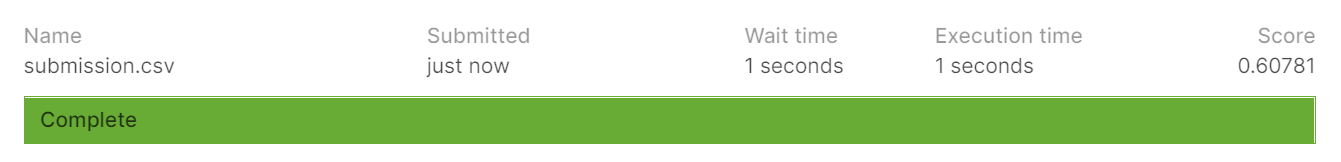

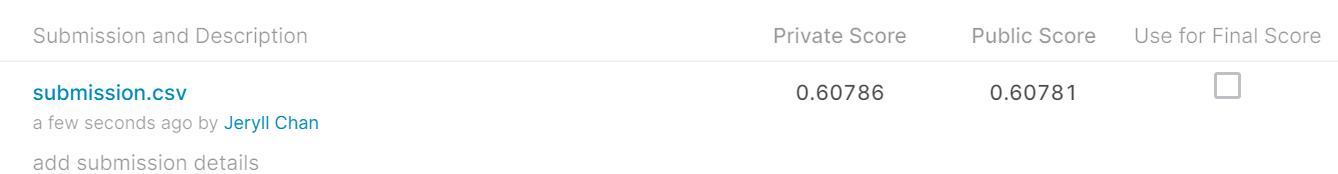

## Section 7: Conclusion & Recommendation

#### Section 7.1: Cost Benefit Analysis

In [167]:
#Cost of Spraying the whole of Chicago

# Area of Chicago (Acres)
Chicago_area = 149800

# Cost of pesticide (https://www.centralmosquitocontrol.com%2F-%2Fmedia%2Ffiles%2Fcentralmosquitocontrol-na%2Fus%2Fresources-lit%2520files%2Fzenivex%2520cost%2520comparison%2520fact%2520sheet.pdf&usg=AOvVaw2oqR8C3sxugwE2lvyIq-I1)
Cost_pesticide_unit = 0.67 #per acre. 

# Peak season for mosquitoes is from April to October.(https://www.callnorthwest.com/2019/05/how-long-does-a-mosquito-treatment-last/)
# It is recommended that mosquito treatments should be applied monthly for the duration of mosquito season.(https://www.callnorthwest.com/2019/05/how-long-does-a-mosquito-treatment-last/)
# Total costs of spraying the whole of chicago, with assumptions above. 
total_costs_nopred = Chicago_area * Cost_pesticide_unit * 5

print('Total cost of spraying the whole of Chicago for is', total_costs_nopred)

Total cost of spraying the whole of Chicago for is 501830.0


In [131]:
# for 117 cases average cost is $136,839 inlcuding implicit cost such as unable to work(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/)

cost = round(136839/117,2)
print(f'Average cost per person is {cost}')


Average cost per person is 1169.56


In [132]:
# 225 WNV cases in Chicago in 2002 is the largest ever case. Thus we take this as worse case scenario without spray (https://www.chicago.gov/content/dam/city/depts/cdph/statistics_and_reports/CDInfo_2013_JULY_WNV.pdf)

annual_cost_treatment = round(cost*225,2)

print(f'Annual average treatment cost in chicago for worse case scenario is {annual_cost_treatment}')

Annual average treatment cost in chicago for worse case scenario is 263151.0


In [133]:
# total net cost for spraying. Total cost of spraying - total benefit of not having WNV present (treatment cost)

net_cost = total_costs_nopred - annual_cost_treatment
print(f'Net cost for spraying whole Chicago is {net_cost}')

Net cost for spraying whole Chicago is 238679.0


In [134]:
# creating a seperate dataset for analysis
train_merged['Predicted'] = preds
df_analysis = train_merged
df_analysis['Predicted'].value_counts(normalize=True)

0    0.7741
1    0.2259
Name: Predicted, dtype: float64

In [135]:
# % area with predicted positive Wnv Present

percentage_area = round((df_analysis['Predicted'].value_counts(normalize=True)[1]),2)
print(f'Estimated % of area to spray using predictive model is {percentage_area*100}%')

Estimated % of area to spray using predictive model is 23.0%


**Note:** Spraying at the predicted location will only need to cover approximately 23% of the total area of Chicago. Hence, the costs of spraying will also be lower by ~77%.

In [136]:
# checking the dataframe is correct
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8610 entries, 0 to 8609
Data columns (total 51 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    8610 non-null   datetime64[ns]
 1   month                   8610 non-null   object        
 2   Species                 8610 non-null   object        
 3   Trap                    8610 non-null   object        
 4   Address                 8610 non-null   object        
 5   Block                   8610 non-null   int64         
 6   Street                  8610 non-null   object        
 7   AddressNumberAndStreet  8610 non-null   object        
 8   Latitude                8610 non-null   float64       
 9   Longitude               8610 non-null   float64       
 10  WnvPresent              8610 non-null   int64         
 11  AddressAccuracy         8610 non-null   int64         
 12  NumMosquitos            8610 non-null   int64   

In [137]:
# function to categorise the confusion matrix

def category(x):
    if x['WnvPresent'] == 1 and x['Predicted'] == 0:
            return 'false negative'
    elif x['WnvPresent'] == 0 and x['Predicted'] == 1:
            return 'false positive'
    elif x['WnvPresent'] == 0 and x['Predicted'] == 0:
            return 'true negative'
    elif x['WnvPresent'] == 1 and x['Predicted'] == 1:
            return 'true positive' 

In [138]:
#map the confusion matrix
df_analysis['category'] = df_analysis.apply(category, axis = 1)
df_analysis.category.value_counts()

true negative     6608
false positive    1545
true positive      400
false negative      57
Name: category, dtype: int64

In [155]:
#Recall = TruePositives / (TruePositives + FalseNegatives)

recall = round(400/(400+57),2)
print('The recall for the predictive model is around', recall)

The recall for the predictive model is around 0.88


In [156]:
# calculate the total spray cost based on the prediction model
total_costs_pred_spray = percentage_area * total_costs_nopred

print('The total costs to spray based on the predictive model is approximately', total_costs_pred_spray)

The total costs to spray based on the predictive model is approximately 115420.90000000001


In [157]:
# assuming we can reduce the number of WNV by the % of correctly spray area for WNV present
total_benfit_pred = annual_cost_treatment*recall
print('The estimated total benefit of correctly sprayed area', total_benfit_pred)

The estimated total benefit of correctly sprayed area 231572.88


In [158]:
# total net cost for spraying. Total cost of spraying - total benefit of not having WNV present (treatment cost)

net_cost_pred = round((total_costs_pred_spray - total_benfit_pred),2)

print(f'Net cost for spraying on predicted area is {net_cost_pred}')

Net cost for spraying on predicted area is -116151.98


In [159]:
# Total savings from the using prediction model

total_savings = round((net_cost - net_cost_pred),2)
print(f'Total savings from using predictive model is {total_savings}')


Total savings from using predictive model is 354830.98


In [160]:
summary = {'without model': {'Total Cost' : total_costs_nopred, 
                             'Total Benefit': annual_cost_treatment,
                            'Net cost/(benefit)' : net_cost},
           'with model' : {'Total Cost' : total_cost_pred, 
                             'Total Benefit': total_benfit_pred,
                            'Net cost/(benefit)' : net_cost_pred}
          
          }

cost_benefit_df = pd.DataFrame(data = summary).T
cost_benefit_df

Total Cost  Total Benefit  Net cost/(benefit)
without model    501830.0      263151.00           238679.00
with model       115420.9      231572.88          -116151.98

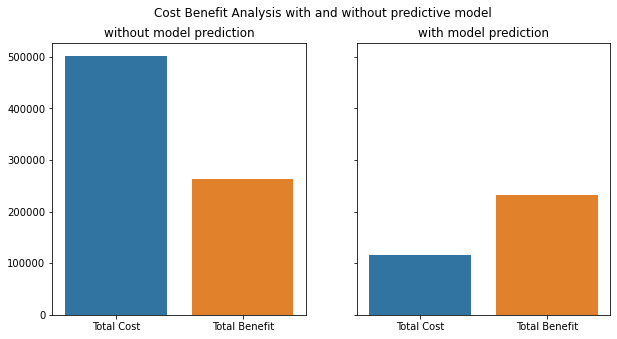

In [161]:
#plotting bar chart
fig, axes = plt.subplots(1, 2, sharey =True, figsize=(10,5))
fig.suptitle('Cost Benefit Analysis with and without predictive model')

sns.barplot(ax=axes[0], data = pd.DataFrame(cost_benefit_df.loc['without model',['Total Cost','Total Benefit']]).T.reset_index(drop=True))
axes[0].set_title('without model prediction')

sns.barplot(ax=axes[1], data = pd.DataFrame(cost_benefit_df.loc['with model',['Total Cost','Total Benefit']]).T.reset_index(drop=True))
axes[1].set_title('with model prediction');

**Conclusion**: From the above calculation, the total saving is estimated to be around US$354830.98 by using prediction model to spray selective areas in Chicago. We can also see from the graph that if we spray selective areas with predictive model, the total benefit outweights the costs, and makes it worthwhile to conduct the spray exercise.